# Irony Simulations
## Imports

In [9]:
import sys
#sys.path.append("/home/sathya/projects/RSAsimulations/src")

import logging
import pickle
from typing import Tuple, List, Optional

#import hydra
import numpy
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
#import omegaconf
import matplotlib
import matplotlib.pyplot as plt
#from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

#import image_captioning.sample as visual_model
#import lexicon
#import physiological
#from image_captioning.build_vocab import Vocabulary
#from pyro.infer.mcmc import MCMC, NUTS
#from pyro.infer import Predictive
#from physiological import ecg_model_forward, ecg_model_inverse, eda_model_forward, eda_model_inverse
#from face import face_model

import utils

from emoclass import *
from preprocess_util import *

# Double precision for numerical stability
torch.set_default_dtype(torch.float64)

## Get Face Image

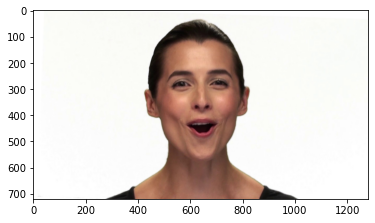

In [6]:
folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames'

image = getEmotionImage(folder_path, 'happy')
plt.imshow(image)

## Get VA from image

In [12]:
IMG_SIZE = 128
NUM_CLASSES = len(emocat)
model_path = "/home/studenti/ballerini/Multimodal_RSA/emoclassmodel.pth"

model = EmoClassCNN(IMG_SIZE, NUM_CLASSES).double()
model.load_state_dict(torch.load(model_path))

pred = predict(model, image, IMG_SIZE)

print('Prediction: ', emocat[pred])

ca_loc = torch.tensor(EMOTION_CORE_AFFECT_MAP_LOC[emocat[pred]])
ca_dev = torch.tensor(EMOTION_CORE_AFFECT_MAP_STD_DEV[emocat[pred]])

valence_dist = dist.Normal(ca_loc[0], ca_dev[0])
arousal_dist = dist.Normal(ca_loc[1], ca_dev[1])

VA = (valence_dist.sample(), arousal_dist.sample())
print(VA)

Prediction:  happy
(tensor(1.0913), tensor(0.9194))


## Loading data and models

In [2]:
STATES: Tuple[str, ...] = ("terrible", "ok", "amazing")
GOALS: Tuple[str, ...] = ("goal_state", "goal_valence", "goal_arousal")
AROUSAL_VALUES: Tuple[str, str] = ("low", "hi")

In [3]:
# Load the configuration file
#CONFIG_PATH = "/home/sathya/projects/RSAsimulations/config/irony_config.yaml"
#cfg = omegaconf.OmegaConf.load(CONFIG_PATH)

## Helper functions

## RSA model priors

In [4]:
STATE_PRIOR = [1, 50, 50]
# Here we introduce the RSA functions - we start with priors
def state_prior() -> str:
    probs: torch.Tensor = torch.FloatTensor(STATE_PRIOR)
    ix: torch.Tensor = pyro.sample("state", dist.Categorical(probs=probs))

    return STATES[ix.item()]

In [5]:
def valence_prior(state: str) -> float:
    # Prior probability of having LOW valence given a particular state
    ps = {"terrible": 0.99, "ok": 0.5, "amazing": 0.01}

    return ps[state]

In [6]:
def arousal_prior(state: str) -> float:
    # Prior probability of having HIGH arousal given a particular state
    ps = {"terrible": 0.9, "ok": 0.1, "amazing": 0.9}

    return ps[state]

In [7]:
def goal_state(goal: str, state, valence, arousal):
    if goal == "goal_state":
        return state
    elif goal == "goal_valence":
        return valence
    elif goal == "goal_arousal":
        return arousal

In [8]:
def goal_prior() -> str:
    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(GOALS)) / len(GOALS)
    goal_index: int = pyro.sample("goal", dist.Categorical(probs=probs)).item()

    return GOALS[goal_index]

In [9]:
def utterance_prior():
    # Utterances and states are equivalent in our case
    utterances = STATES

    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(utterances)) / len(utterances)
    utterance_index: int = pyro.sample("utterance", dist.Categorical(probs=probs)).item()

    return utterances[utterance_index]


## RSA model core functions

In [10]:
# Sampling valence given state and any other sources of valence
def sample_valence(state) -> int:
    sampled_valence_prior = valence_prior(state)

    sample = pyro.sample(
        "valence_prior",
        dist.Bernoulli(probs=sampled_valence_prior)
    ).item()

    # Recall that the probabilities are inverted for valence in the prior
    return -1 if sample == 1 else 1

In [11]:
# Sampling arousal given state and any other sources of arousal
def sample_arousal(state):
    sampled_arousal_prior = arousal_prior(state)

    sample = pyro.sample(
        "arousal_prior",
        dist.Bernoulli(probs=sampled_arousal_prior)
    ).item()

    # Here the probabilities are not inverted
    return AROUSAL_VALUES[int(sample)]


In [12]:
# Define RSA meaning function
def literal_interpretation(utterance: str, state: str) -> bool:
    # This is our meaning function
    return utterance == state

In [13]:
# Literal listener
@utils.marginal
def literal_listener(utterance, goal):
    sampled_state = state_prior()

    sampled_valence = sample_valence(sampled_state)
    sampled_arousal = sample_arousal(sampled_state)

    sampled_goal = goal_state(goal, sampled_state, sampled_valence, sampled_arousal)

    log_factor: torch.Tensor = torch.tensor(0.0) if literal_interpretation(utterance, sampled_state) \
        else torch.tensor(-999999.0)
    pyro.factor("literal_meaning", log_factor=log_factor)

    return sampled_goal

In [14]:
# Pragmatic speaker
@utils.marginal
def pragmatic_speaker(state: str, valence: float, arousal: float, goal: str) -> str:
    alpha_scaling_factor: float = 1.0

    sampled_goal: str = goal_state(goal, state, valence, arousal)

    with poutine.scale(scale=torch.tensor(alpha_scaling_factor)):
        sampled_utterance = utterance_prior()
        literal_listener_goal = literal_listener(sampled_utterance, goal)
        pyro.sample("listener", literal_listener_goal, obs=sampled_goal)

    return sampled_utterance

In [15]:
# Pragmatic listener
@utils.marginal
def pragmatic_listener(utterance: str):
    sampled_state = state_prior()
    sampled_valence = sample_valence(
        sampled_state
    )
    sampled_arousal = sample_arousal(
        sampled_state
    )
    sampled_goal = goal_prior()

    speaker_marginal = pragmatic_speaker(sampled_state, sampled_valence, sampled_arousal, sampled_goal)
    pyro.sample("speaker", speaker_marginal, obs=utterance)

    return sampled_state, sampled_valence, sampled_arousal, sampled_goal

## Experiments

In [16]:
PLOT_WIDTH = 15
PLOT_HEIGHT = 8
matplotlib.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT]

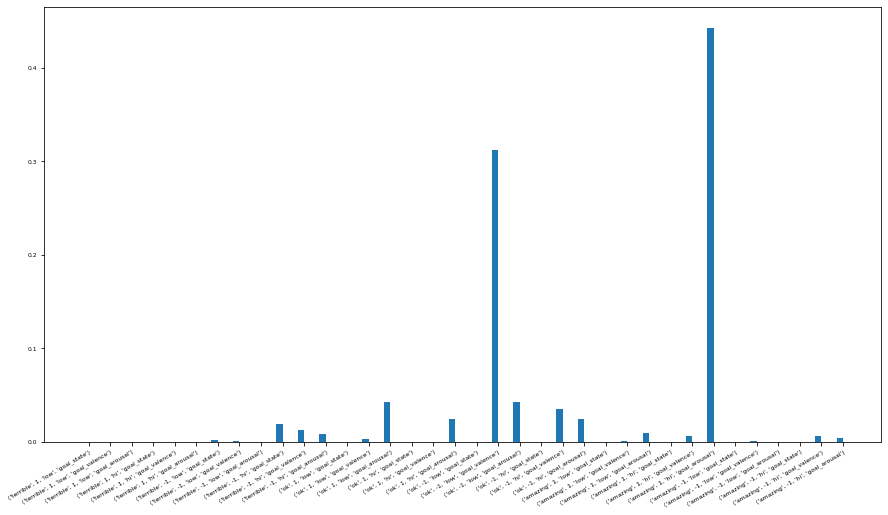

In [17]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_terrible.pdf")

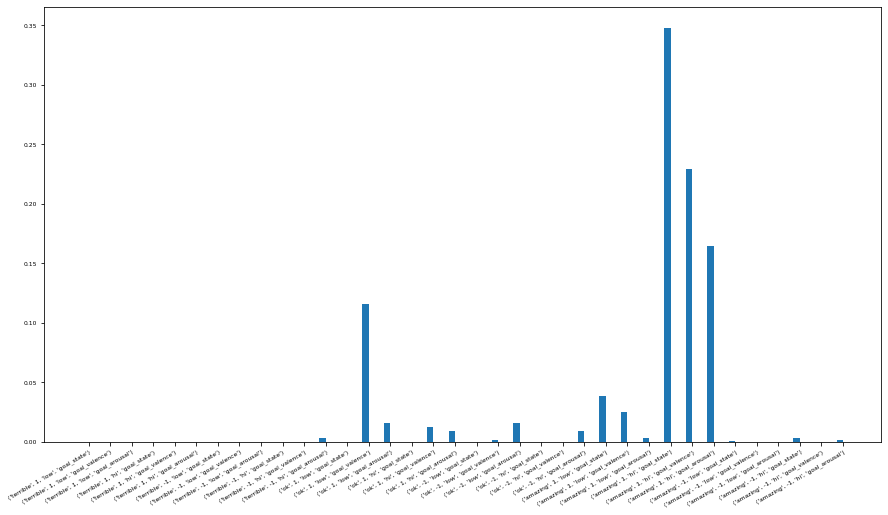

In [18]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_amazing.pdf")

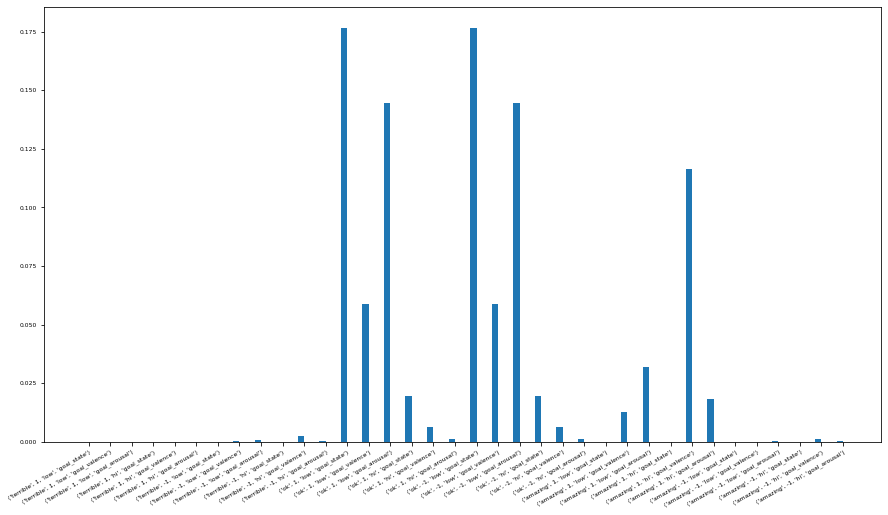

In [19]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("ok")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_ok.pdf")

### Altering the state prior

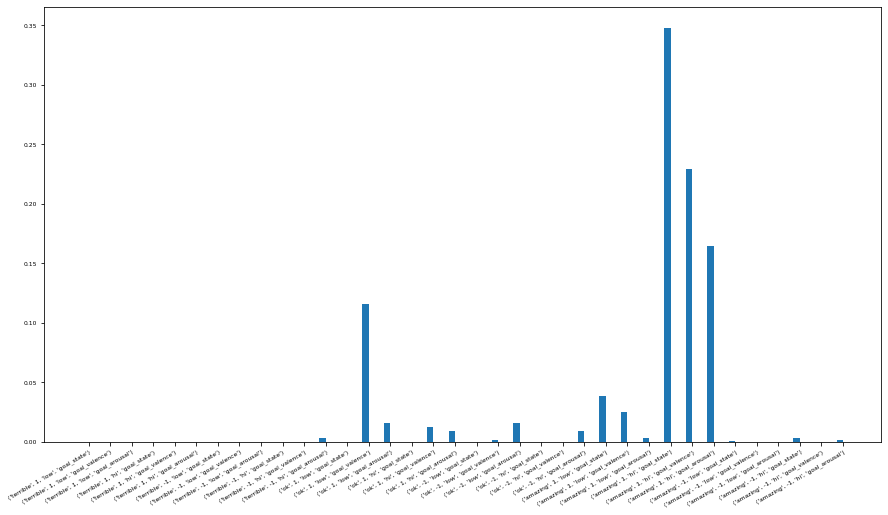

In [20]:
STATE_PRIOR = [1, 50, 1]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_.pdf")

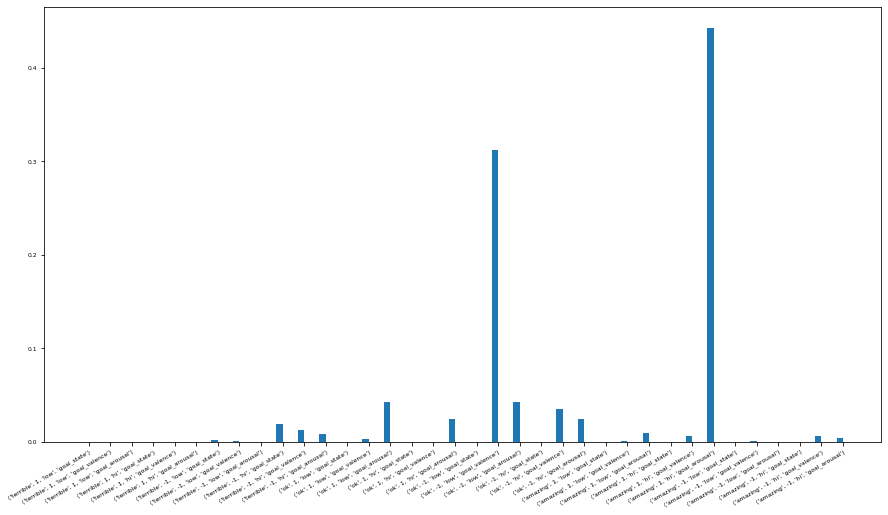

In [21]:
STATE_PRIOR = [100, 1, 1]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_.pdf")